# TP4 - Background Substraction
ATRIM - Option Datasim

Ecole Centrale Nantes

Diana Mateus

Participants: (FILL IN YOUR NAMES AND LASTNAMES)

### BACKGROUND SUBSTRACTION 

The goal of this TP is to enhance the video of a neurointervention  to improve the visualization of moving tools. To this end you will implement a pipeline of image processing methods to detect the moving tools automatically. 


#### Methodology

As the brain is mostly static one way to detect the moving tools is to substract the background (first image) from each of the subsequent images. However, the results of this step need to be further improved. To this end, you will design a pipilene with the methods learnt in this course to produce a binary mask for the pixels that belong to the tools. 

In your pipeline use at least:
- one histogram transformation
- one morphological operation
- one filtering operation in the spatial domain
- one filtering operation in the spectral domain
- one segmentation method

_The same pipeline should be applied to every image_


#### Expected output

The output of your image processing pipeline should be one binary image mask (with values 0 or 1) for every input image of the sequence, where 
- the zero valued pixels indicate the moving tools inside each image.  
- the pixels with value 1 indicate the background (not a moving tool)

To validate the proposed method, a human has annotated (manually drawn) the tools of interest within the images. The annotated pixels belong either to catheters or guidewires. **Your masks should be as close as possible to the human annotations.**


#### Visualization of data and manual annotations

- Data visualization  (**do not include in final version**): visualize the neurointervention images in the ``` catheter``` folder with name ```frame_#```

- Individual Annotation visualization  (** do not include in final version**): visualize the manual annotations in the ```catheter``` folder with names ``` #_MicroCath``` and ```#_GuideWire```. 

- Individual Annotation visualization  (** do not include in final version**): visualize the full manual annotation (union of the guidewire and microcatheter masks) by composing the union of the ``` #_MicroCath``` and ```#_GuideWire```. It should also be a binary mask.



#### Experimental (quantitative and qualitative  validation)

To compare your results and the manual annotations use the mean SAD (Sum of Absolute Differences) and the SNR (Signal to Noise Ratio) errors between your  mask and  the **full** manual mask. 

Present the results qualitatively and quantitatively:

- Qualitatively: 
     - Show your mask side by side with the manually annotated mask
     - Create an enhanced image suitable for guidance: enhance the contrast of the image and overlay your mask on the green channel of the enhanced image.

- Quantitatively: 
    - compute and print the SAD (sum of absolute differences) error per image. 
    - compute and print the MSE (sum of squared  differences ) error per image.
    - compute and print the PSNR (Peak signal to noise ratio) taking as reference image the manual annotations. 
    - Then compute and print the mean and standard deviation of the three measures (SAD, MSE and PSNR) over the entire sequence.
    
Hints:
```
mse = numpy.mean( (img1 - img2) ** 2 )
PIXEL_MAX = 255.0 #or 1.0 or max over the signal of interest
psnr = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
```
or look at ```skimage.measure``` module

You may use modules such as ```scipy```, ```skimage``` or ``sklearn``(e.g. for clustering with K-means or a Gaussian Mixture Model). Ask me for other external modules.


### REPORT INSTRUCTIONS

#### 1. Intermediate Steps (Code and Description)
Report the results of the intermediate steps (when you add or remove a method from the pipeline):
- provide a text introduction with the idea that you intend to try
- show the implementation of the idea with code 
- evaluate the quantitative and qualitative changes  when including, varying, adapting, etc the proposed method
- Discuss the scores or visualization improvements/degradations 

#### 2. Final Pipeline (Code and Description)
Provide a detailed description of the best performing pipeline. Comment the code such that it is straightforward to relate the pipeline description to the code. Add your conclusions

- Describe the final retained pipeline
- Give a justification for every step (e.g. supported by experimental intermediate steps or theory). 
- Add the **commented** code
- Display the qualitative and quantitative results 
- Give your conclusions

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage.io as io
from scipy import ndimage

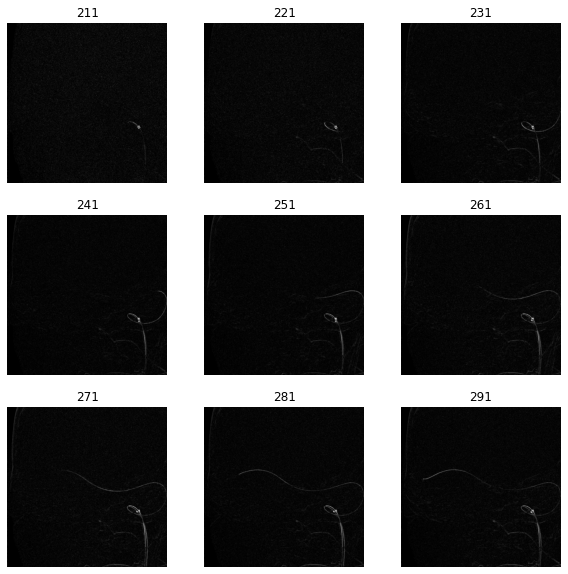

In [2]:
IMDIR = 'catheter'
fig=plt.figure(figsize=(10, 10))

frames = {}

for root, dirnames, filenames in os.walk(IMDIR):
    for filename in filenames:
        f = os.path.join(root, filename)
        if filename.startswith(('frame_')):
            if filename.endswith('201'):
                background = io.imread(f, as_gray=True).astype('float') / 255
            else:
                frames[filename[-3:]] = io.imread(f, as_gray=True).astype('float') / 255
                
diff = frames.copy()
for key in frames:
    diff[key] = abs(frames[key] - background)   
    
i = 1
for key in diff:
    plt.subplot(3, 3, i)
    plt.imshow(diff[key], cmap='gray')
    plt.axis('off')
    plt.title(key)
    i += 1
    
plt.show()

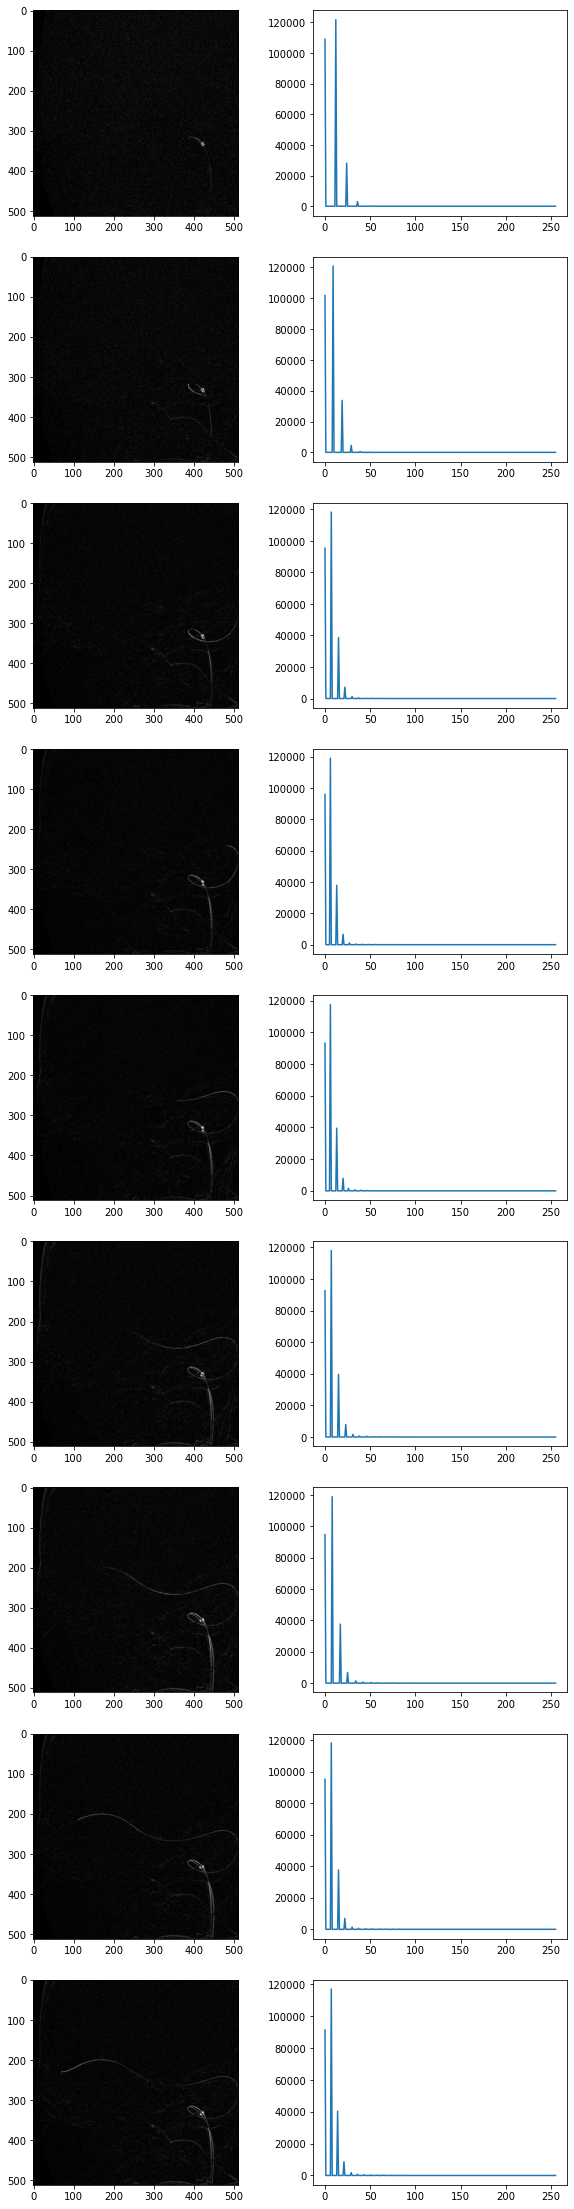

In [3]:
fig=plt.figure(figsize=(10, 40))

i = 1
for key in diff:
    hist, _ = np.histogram(diff[key], bins=256)
    plt.subplot(9, 2, i)
    plt.imshow(diff[key], cmap='gray')
    plt.subplot(9, 2, i+1)
    plt.plot(hist)
    i += 2

plt.show()

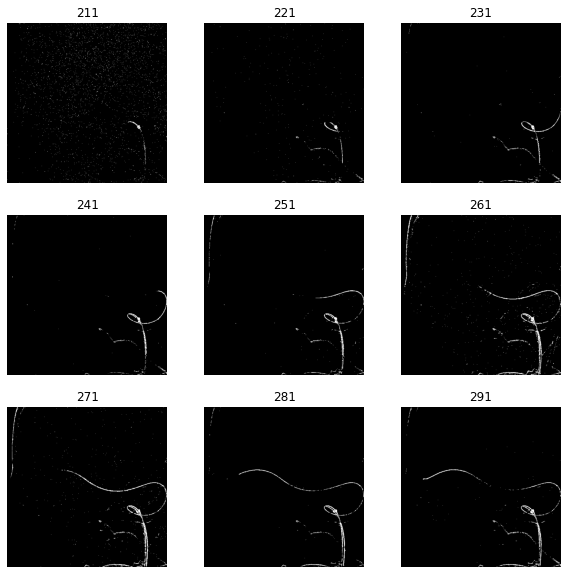

In [4]:
fig=plt.figure(figsize=(10, 10))

diff_threshold = diff.copy()

i = 1
for key in diff:
    diff_threshold[key] = np.where(diff[key] < 0.12 * np.max(diff[key]), 0, 1)
    plt.subplot(3, 3, i)
    plt.imshow(diff_threshold[key], cmap='gray')
    plt.axis('off')
    plt.title(key)
    i += 1

plt.show()

<ipython-input-59-c11c086cc9f8>:44: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(diff_threshold[key])))), cmap='gray')


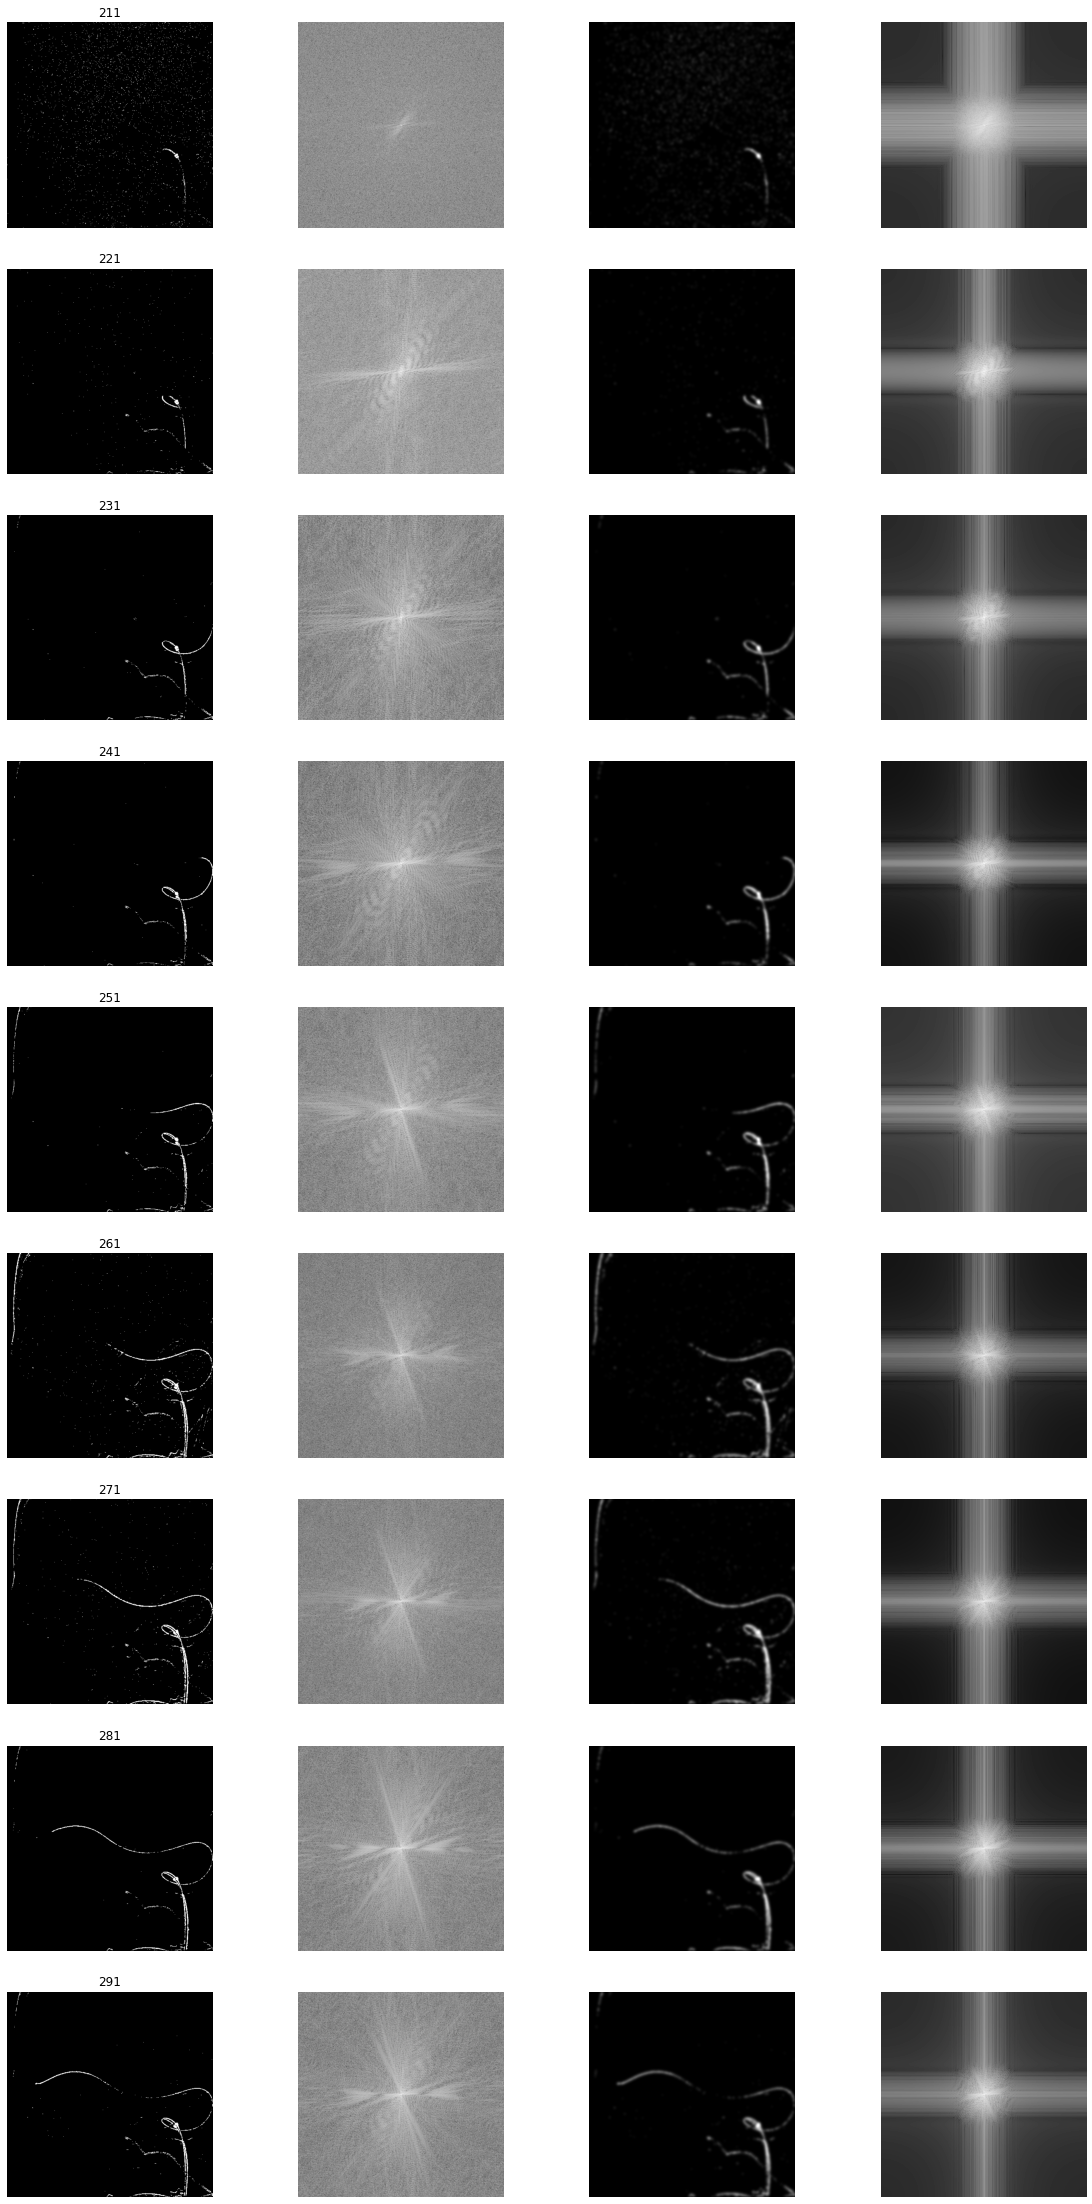

In [59]:
def lowpass_filter(D, shape, filter_type='ideal'):
    Q, P = shape
    if filter_type == 'ideal':
        lowpass = np.array([[int((u - P//2)**2 + (v - Q//2)**2 < D**2) for u in range(P)] for v in range(Q)])
    else:
        lowpass = np.array([[ np.exp(-((u - P//2)**2 + (v - Q//2)**2 )/(2*D**2)) for u in range(P)]for v in range(Q)])
    return lowpass

def highpass_filter(D,shape,filter_type='ideal'):
    Q, P = shape
    if filter_type == 'ideal':
        lowpass = np.array([[int((u - P//2)**2 + (v - Q//2)**2 > D**2) for u in range(P)] for v in range(Q)])
    else:
        lowpass = 1-lowpass_filter(D,shape,'gaussian')
    return lowpass

def apply_filter(im, f):
    N, M = im.shape
    im_padded = np.zeros((2*N, 2*M))
    im_padded[0:N,0:M] = im
    im_fft = np.fft.fft2(im_padded)
    im_fft = np.fft.fftshift(im_fft)
    res_fft = f * im_fft
    res = np.fft.ifft2(np.fft.ifftshift(res_fft))
    res = np.real(res)
    res = res[:N, :M]
    
    return res

H, W = background.shape
lowpass = lowpass_filter(50, (2*H,2*W), 'gauss')

diff_filtered = diff_threshold.copy()

fig=plt.figure(figsize=(20, 40))

i = 1
for key in diff_threshold:
    plt.subplot(9, 4, i)
    plt.imshow(diff_threshold[key], cmap='gray')
    plt.title(key)
    plt.axis('off')
    plt.subplot(9, 4, i+1)
    plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(diff_threshold[key])))), cmap='gray')
    plt.axis('off')
    diff_filtered[key] = apply_filter(diff_threshold[key], lowpass)
    plt.subplot(9, 4, i+2)
    plt.imshow(diff_filtered[key], cmap='gray')
    plt.axis('off')
    plt.subplot(9, 4, i+3)
    plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(diff_filtered[key])))), cmap='gray')
    plt.axis('off')
    i += 4
    
plt.show()

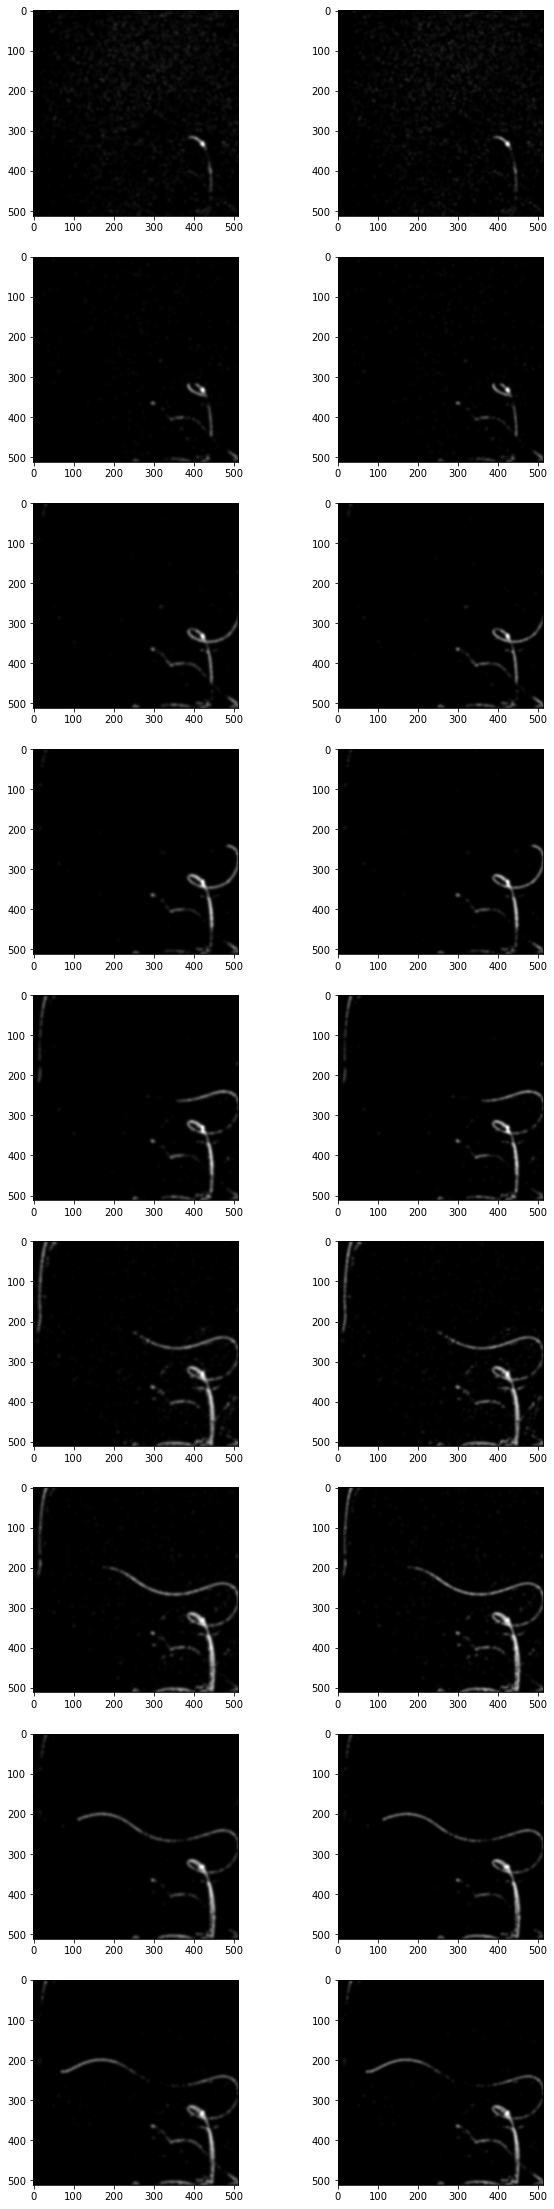

In [44]:
def generateLaplacianKernel():
    return np.array([[0,1,0], [1,-4,1], [0,1,0]])

def laplacianEnhance(im,c):
    kernelL =generateLaplacianKernel()
    laplaceImg=ndimage.convolve(im,kernelL)
    im_sharp = im+c*laplaceImg
    return im_sharp

i=1
fig=plt.figure(figsize=(10, 40))

for key in diff_threshold:
    plt.subplot(9, 2, i)
    im_enhance=laplacianEnhance(diff_filtered[key],-1)
    plt.imshow(diff_filtered[key], cmap = 'gray')
    plt.subplot(9, 2, i+1)
    plt.imshow(im_enhance, cmap = 'gray')
    i+=2

NameError: name 'value' is not defined

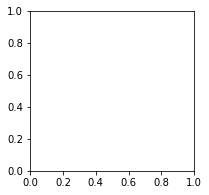

In [31]:
fig=plt.figure(figsize=(10, 10))

from skimage.morphology import dilation
from skimage.morphology import disk

selem = disk(4)

i = 1
for key in diff:
    diff[key] = dilation(diff[key], selem)
    plt.subplot(3, 3, i)
    plt.imshow(value, cmap='gray')
    plt.axis('off')
    plt.title(key)
    i += 1

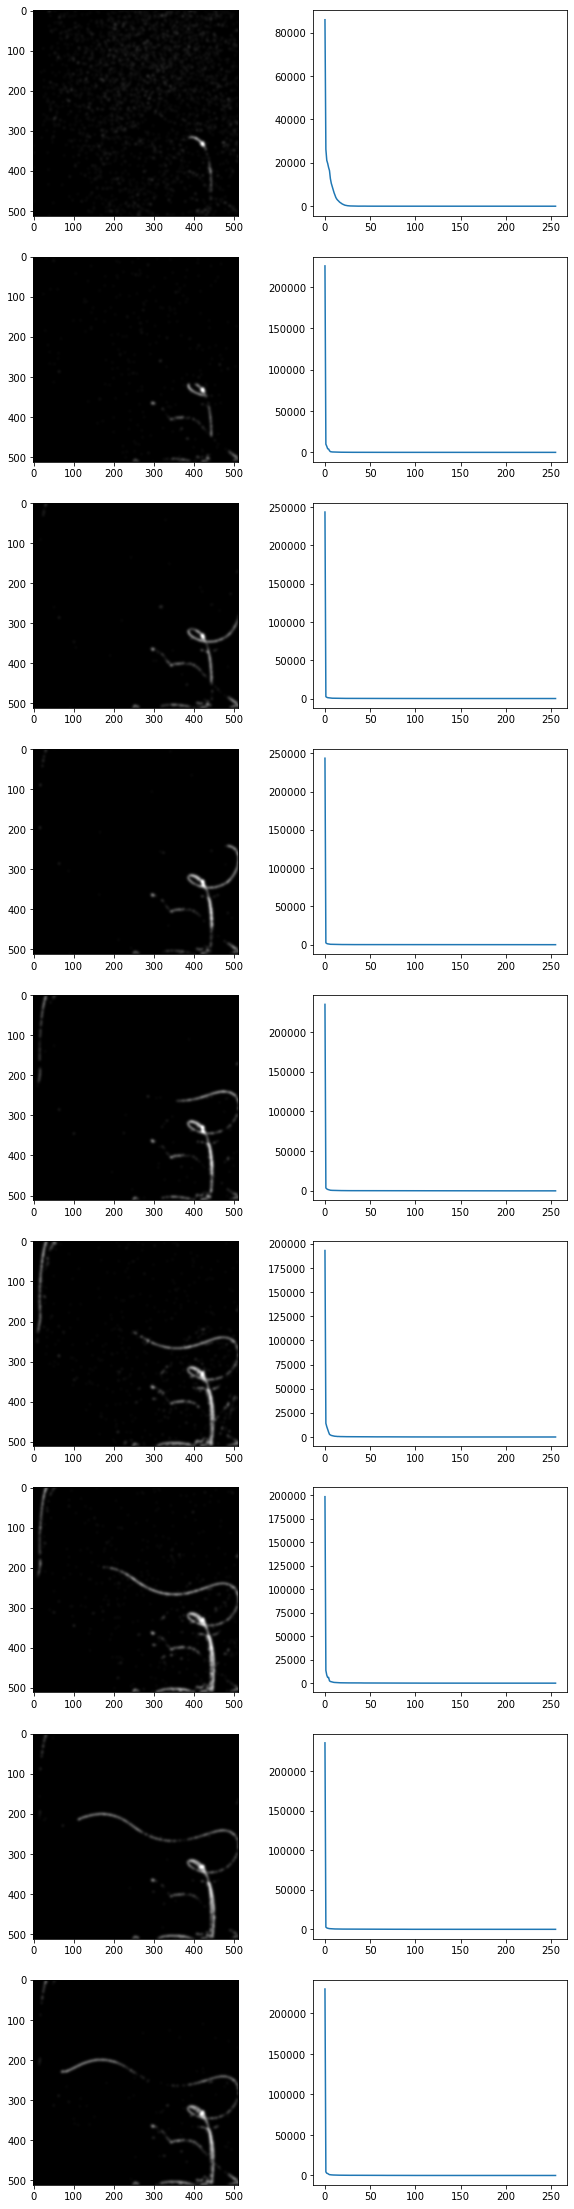

In [61]:
fig=plt.figure(figsize=(10, 40))

i = 1
for key in diff_filtered:
    hist, _ = np.histogram(diff_filtered[key], bins=256)
    plt.subplot(9, 2, i)
    plt.imshow(diff_filtered[key], cmap='gray')
    plt.subplot(9, 2, i+1)
    plt.plot(hist)
    i += 2

plt.show()

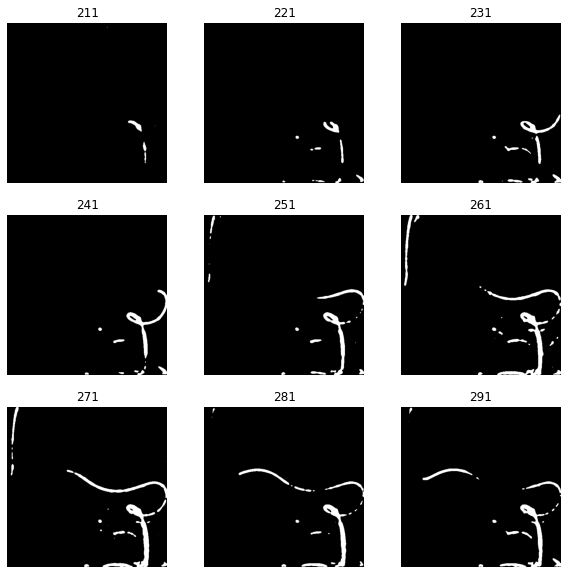

In [64]:
fig=plt.figure(figsize=(10, 10))

diff_filtered_threshold = diff_filtered.copy()

i = 1
for key in diff:
    diff_filtered_threshold[key] = np.where(diff_filtered[key] < 0.15 * np.max(diff_filtered[key]), 0, 1)
    plt.subplot(3, 3, i)
    plt.imshow(diff_filtered_threshold[key], cmap='gray')
    plt.axis('off')
    plt.title(key)
    i += 1

plt.show()